- get qiskit

In [1]:
import qiskit
print(qiskit.version.get_version_info())

C:\Users\slipo\anaconda3\envs\old_qiskit\lib\site-packages\qiskit\circuit\equivalence.py:18: DeprecationWarning: The retworkx package is deprecated and has been renamed to rustworkx. Rustworkx is a drop-in replacement and can be used by replacing `import retworkx` with import `rustworkx`. 
  import retworkx as rx
C:\Users\slipo\anaconda3\envs\old_qiskit\lib\site-packages\qiskit\version.py:20: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


0.18.1


- import needed libraries

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import Aer,execute
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

- define display graph functions

In [3]:
def visualize_graph(edges):
    # Create the graph
    G = nx.Graph()
    G.add_edges_from(edges)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    #nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=1000, font_size=12)
    nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=1000, font_size=12)
    plt.title("Graph Visualization")
    plt.show()

In [4]:
def visualize_bipartite_graph(n,edges):
    # Create the graph
    G = nx.Graph()
    G.add_edges_from(edges)

    # Define node positions for better visualization
    pos = {}
    for i in range(int(n/2)):
        pos[i] = (0, i)  # Left side
    for j in range(int(n/2), n):
        pos[j] = (1, j - int(n/2))  # Right side

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=1000, font_size=12)
    plt.title("Complete Bipartite Graph")
    plt.show()

- qiskit code to identify if a given graph is a bipartite graph

In [5]:
def create_oracle(n_vertices, edges):
    """Creates quantum oracle for bipartite checking"""
    num_edges = len(edges)
    total_qubits = n_vertices + num_edges + 1
    qc = QuantumCircuit(total_qubits, name="Oracle")
    
    edge_ancillas = list(range(n_vertices, n_vertices + num_edges))
    flag_qubit = n_vertices + num_edges
    
    # Check each edge for same-color violation
    for i, (u, v) in enumerate(edges):
        edge_anc = edge_ancillas[i]
        qc.cx(u, edge_anc)
        qc.cx(v, edge_anc)
        qc.x(edge_anc)
    
    # Aggregate violations using XOR operation
    for anc in edge_ancillas:
        qc.cx(anc, flag_qubit)
    
    # Apply phase flip when no violations (flag=0)
    qc.x(flag_qubit)
    qc.z(flag_qubit)
    qc.x(flag_qubit)
    
    # Uncompute operations
    for anc in reversed(edge_ancillas):
        qc.cx(anc, flag_qubit)
    
    for i, (u, v) in reversed(list(enumerate(edges))):
        edge_anc = edge_ancillas[i]
        qc.x(edge_anc)
        qc.cx(v, edge_anc)
        qc.cx(u, edge_anc)
    
    return qc

def get_partitions(bitstring, n_vertices):
    """Extracts partitions from measurement result"""
    reversed_bits = bitstring[::-1]
    node_bits = reversed_bits[:n_vertices]
    return (
        [i for i, bit in enumerate(node_bits) if bit == '0'],
        [i for i, bit in enumerate(node_bits) if bit == '1']
    )

def is_valid(bitstring, edges, n_vertices):
    """Validates bipartition against edges"""
    set_a, set_b = get_partitions(bitstring, n_vertices)
    return all((u in set_a) != (v in set_a) for u, v in edges)

# For n nodes and M valid solutions:
def grover_iterations(n, M=2):
    N = 2 ** n
    R_raw = (math.pi/4) * math.sqrt(N/M) - 0.5
    return max(0, int(math.floor(R_raw)))

def check_if_bipartite(n,edges):
    # Create quantum components
    oracle = create_oracle(n, edges)
    state_prep = QuantumCircuit(oracle.num_qubits)
    state_prep.h(range(n))  # Initialize superposition

    # Configure Grover's algorithm
    iterations = grover_iterations(n, M=2)
    print("iterations:",iterations)

    grover = Grover(iterations=iterations)
    problem = AmplificationProblem(
       oracle=oracle,
       state_preparation=state_prep,
       is_good_state=lambda x: is_valid(x, edges, n)
    )

    # Construct and measure circuit
    circuit = grover.construct_circuit(problem)
    circuit.measure_all()

    circuit.draw(output='mpl', fold=100)

    # Execute on QASM simulator
    backend = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend, shots=1000).result()
    counts = result.get_counts()

    # Analyze results
    valid_results = [bs for bs in counts if is_valid(bs, edges, n)]

    if valid_results:
        best_result = max(valid_results, key=lambda x: counts[x])
        part_a, part_b = get_partitions(best_result, n)
        print("Bipartite Graph Detected 𓇢")
        print(f"Partition A ({len(part_a)} nodes): {sorted(part_a)}")
        print(f"Partition B ({len(part_b)} nodes): {sorted(part_b)}")
        print(f"Confidence: {counts[best_result]/1000:.1%}")
    else:
        print("❌ Graph is not bipartite")

## Testing

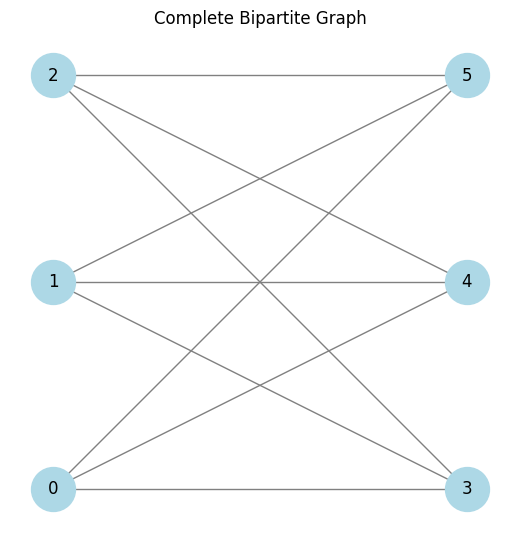

iterations: 3
Bipartite Graph Detected 𓇢
Partition A (3 nodes): [3, 4, 5]
Partition B (3 nodes): [0, 1, 2]
Confidence: 1.9%


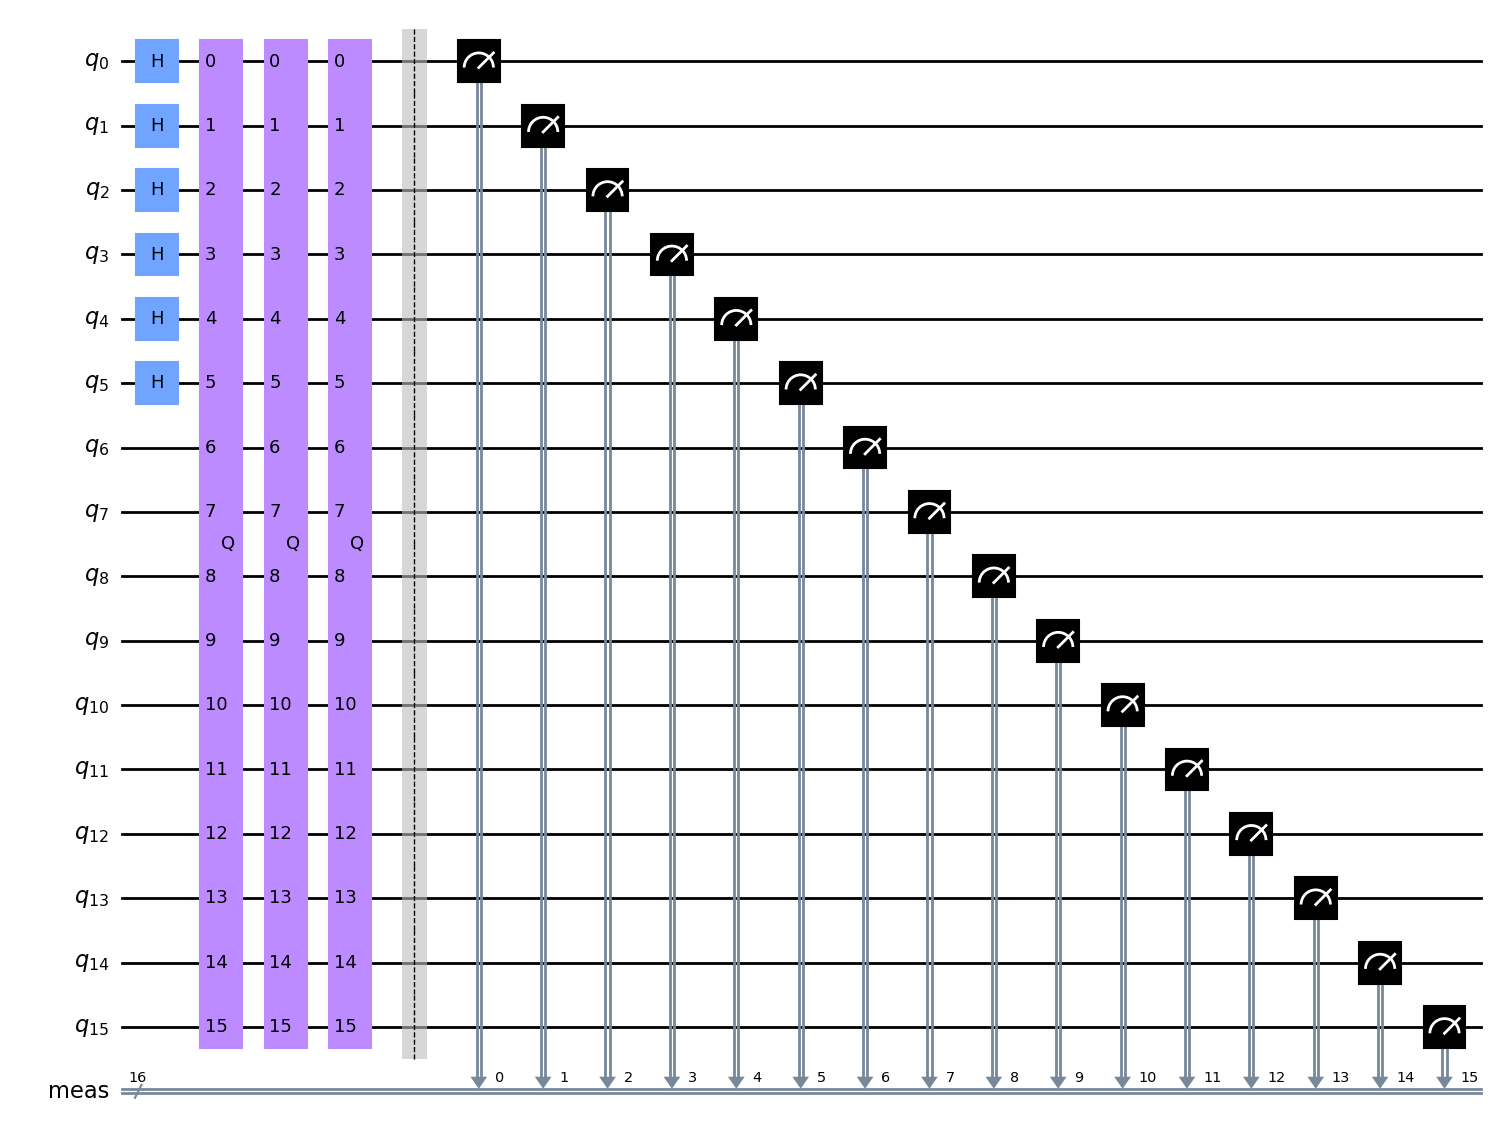

In [6]:
# Test case: 6-node bipartite graph
n = 6
edges = [(i, j) for i in range(3) for j in range(3, 6)]  # Complete bipartite graph K₅,₅

visualize_bipartite_graph(n,edges)
check_if_bipartite(n,edges)

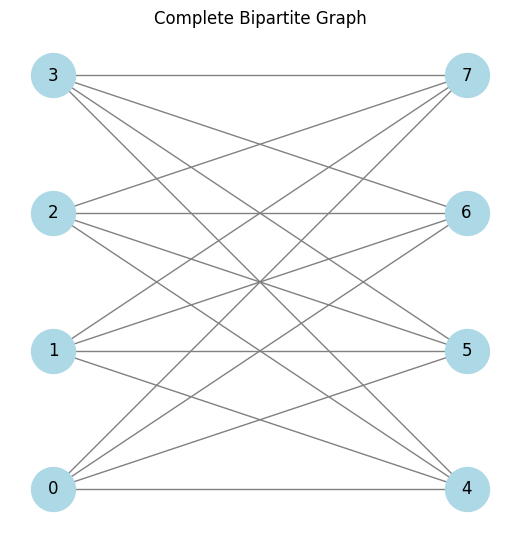

iterations: 8
Bipartite Graph Detected 𓇢
Partition A (4 nodes): [0, 1, 2, 3]
Partition B (4 nodes): [4, 5, 6, 7]
Confidence: 0.7%


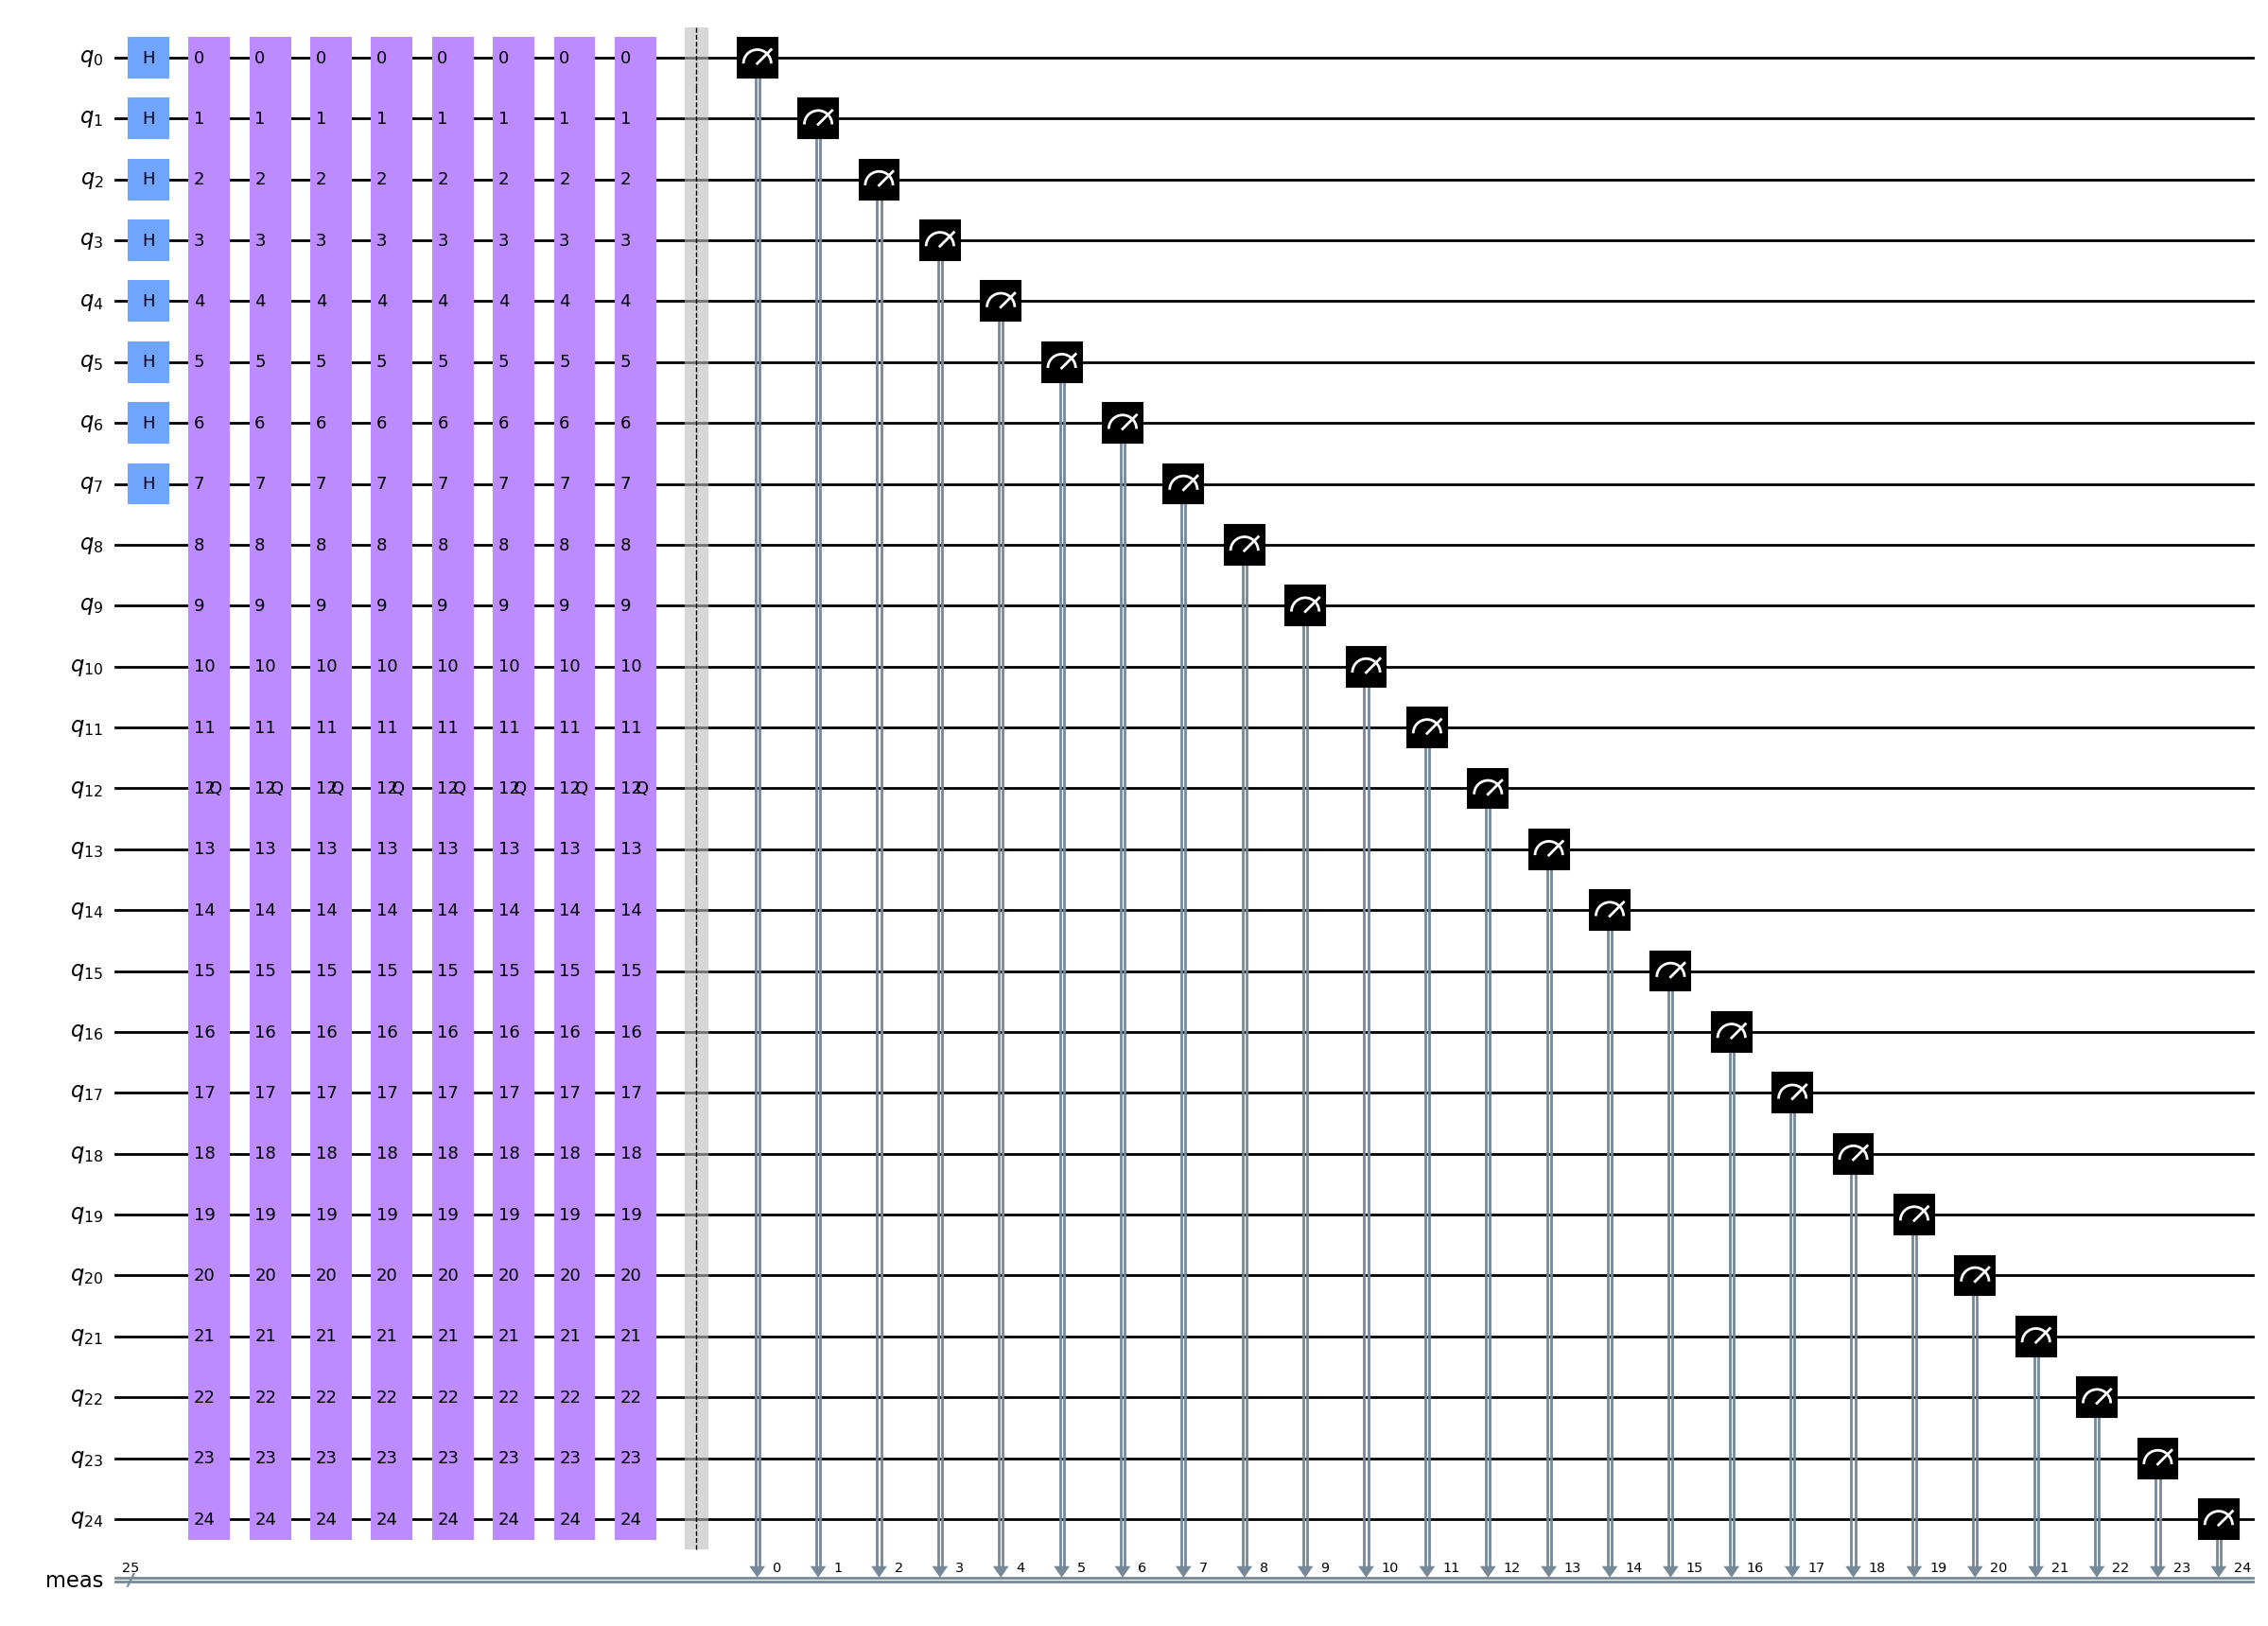

In [7]:
# Test case: 8-node bipartite graph
n = 8
edges = [(i, j) for i in range(4) for j in range(4, 8)]  # Complete bipartite graph K₅,₅

visualize_bipartite_graph(n,edges)
check_if_bipartite(n,edges)

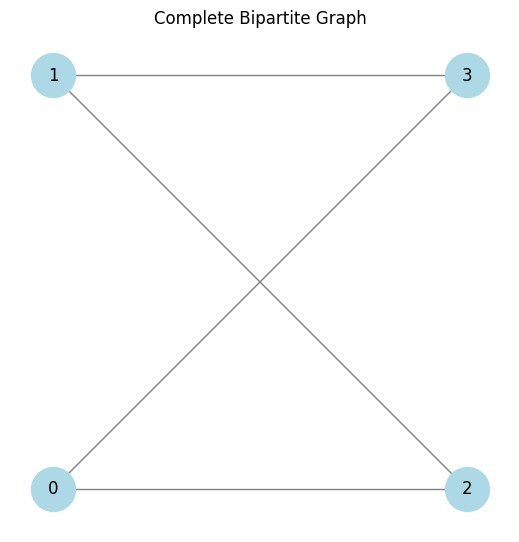

iterations: 1
Bipartite Graph Detected 𓇢
Partition A (2 nodes): [0, 1]
Partition B (2 nodes): [2, 3]
Confidence: 6.1%


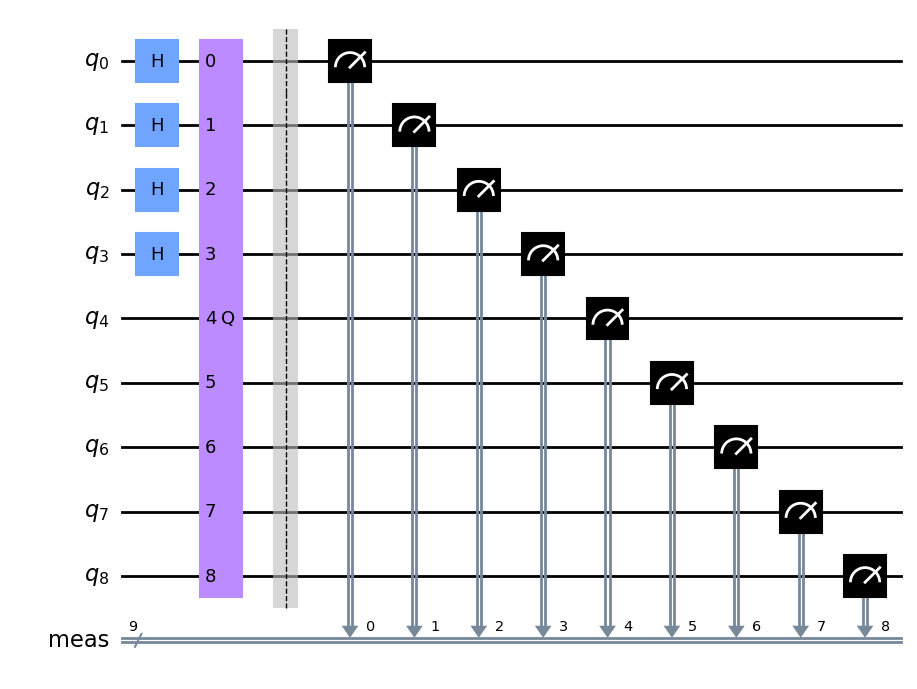

In [8]:
# Test case: 4-node bipartite graph
n = 4
edges = [(i, j) for i in range(2) for j in range(2, 4)]  # Complete bipartite graph K₅,₅

visualize_bipartite_graph(n,edges)
check_if_bipartite(n,edges)

- display oracle circuit

In [9]:
def dissect_create_oracle(n_vertices, edges):
    """Creates quantum oracle for bipartite checking"""
    num_edges = len(edges)
    total_qubits = n_vertices + num_edges + 1
    qc = QuantumCircuit(total_qubits, name="Oracle")
    
    edge_ancillas = list(range(n_vertices, n_vertices + num_edges))
    flag_qubit = n_vertices + num_edges
    
    # Check each edge for same-color violation
    for i, (u, v) in enumerate(edges):
        edge_anc = edge_ancillas[i]
        qc.cx(u, edge_anc)
        qc.cx(v, edge_anc)
        qc.x(edge_anc)
    qc.barrier()
    
    # Aggregate violations using XOR operation
    for anc in edge_ancillas:
        qc.cx(anc, flag_qubit)
    qc.barrier()
    
    # Apply phase flip when no violations (flag=0)
    qc.x(flag_qubit)
    qc.z(flag_qubit)
    qc.x(flag_qubit)
    qc.barrier()
    
    # Uncompute operations
    for anc in reversed(edge_ancillas):
        qc.cx(anc, flag_qubit)
    qc.barrier()
    
    for i, (u, v) in reversed(list(enumerate(edges))):
        edge_anc = edge_ancillas[i]
        qc.x(edge_anc)
        qc.cx(v, edge_anc)
        qc.cx(u, edge_anc)
    qc.barrier()
    
    return qc

Figure(3130.27x785.944)


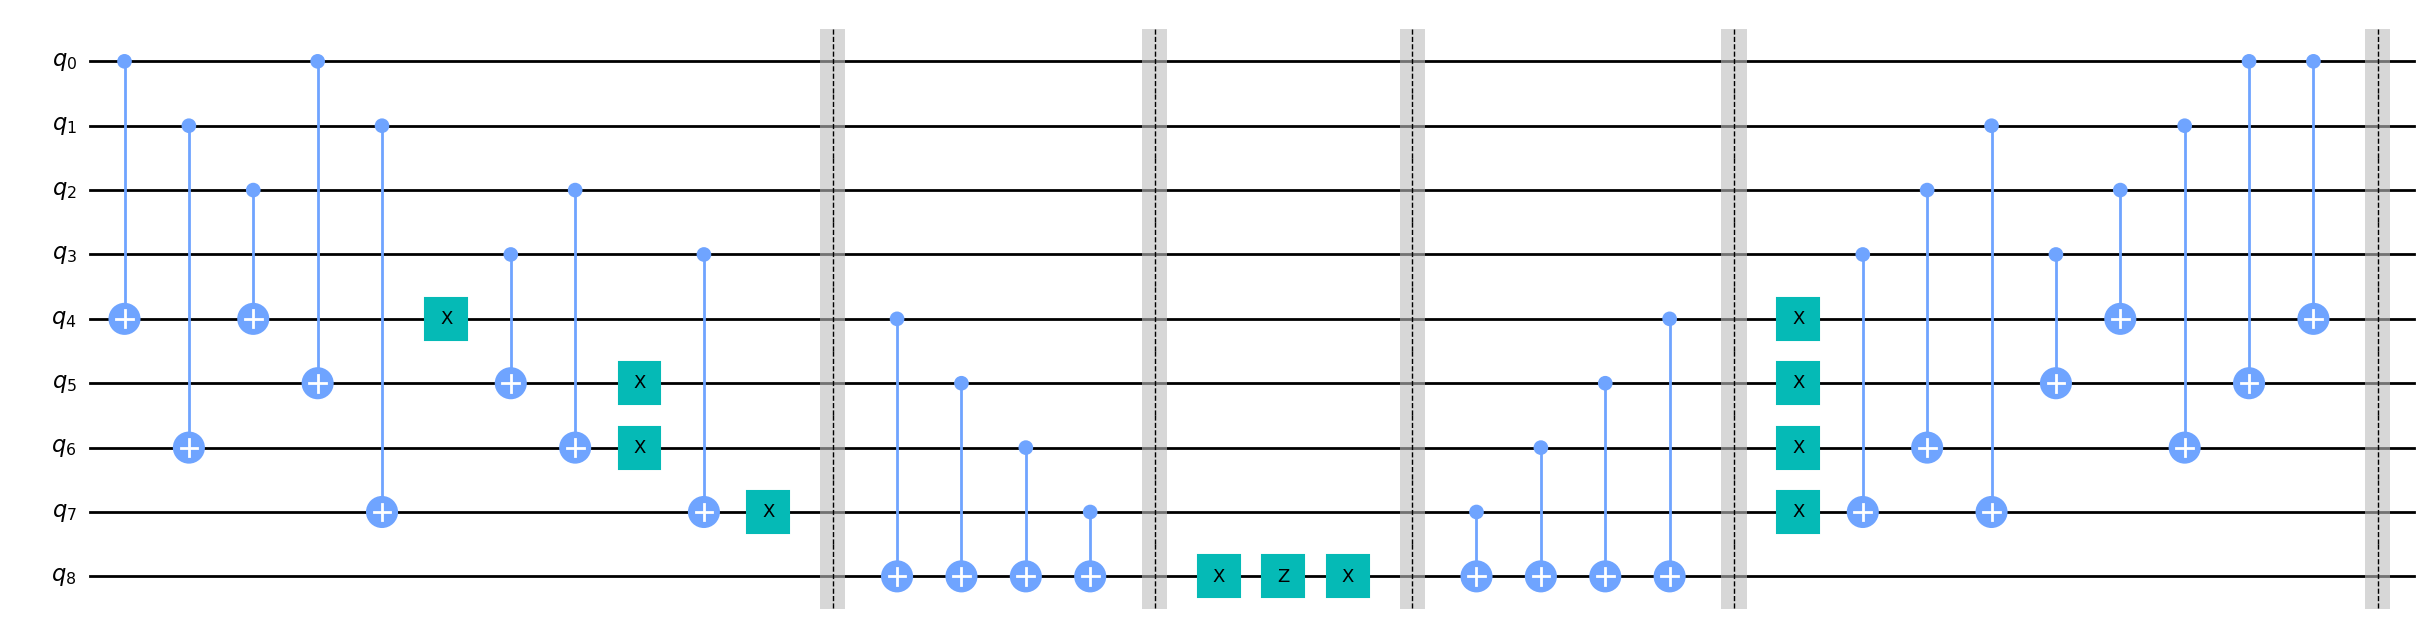

In [10]:
qc = dissect_create_oracle(n,edges)
print(qc.draw(output='mpl', fold=100))

- some arbitrary 6-nodes graph

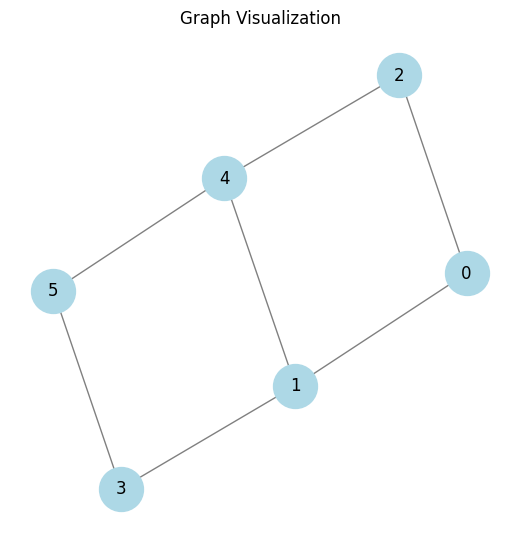

In [11]:
n=6
edges = [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 5), (1, 4)]
visualize_graph(edges)

iterations: 3
Bipartite Graph Detected 𓇢
Partition A (3 nodes): [1, 2, 5]
Partition B (3 nodes): [0, 3, 4]
Confidence: 1.5%


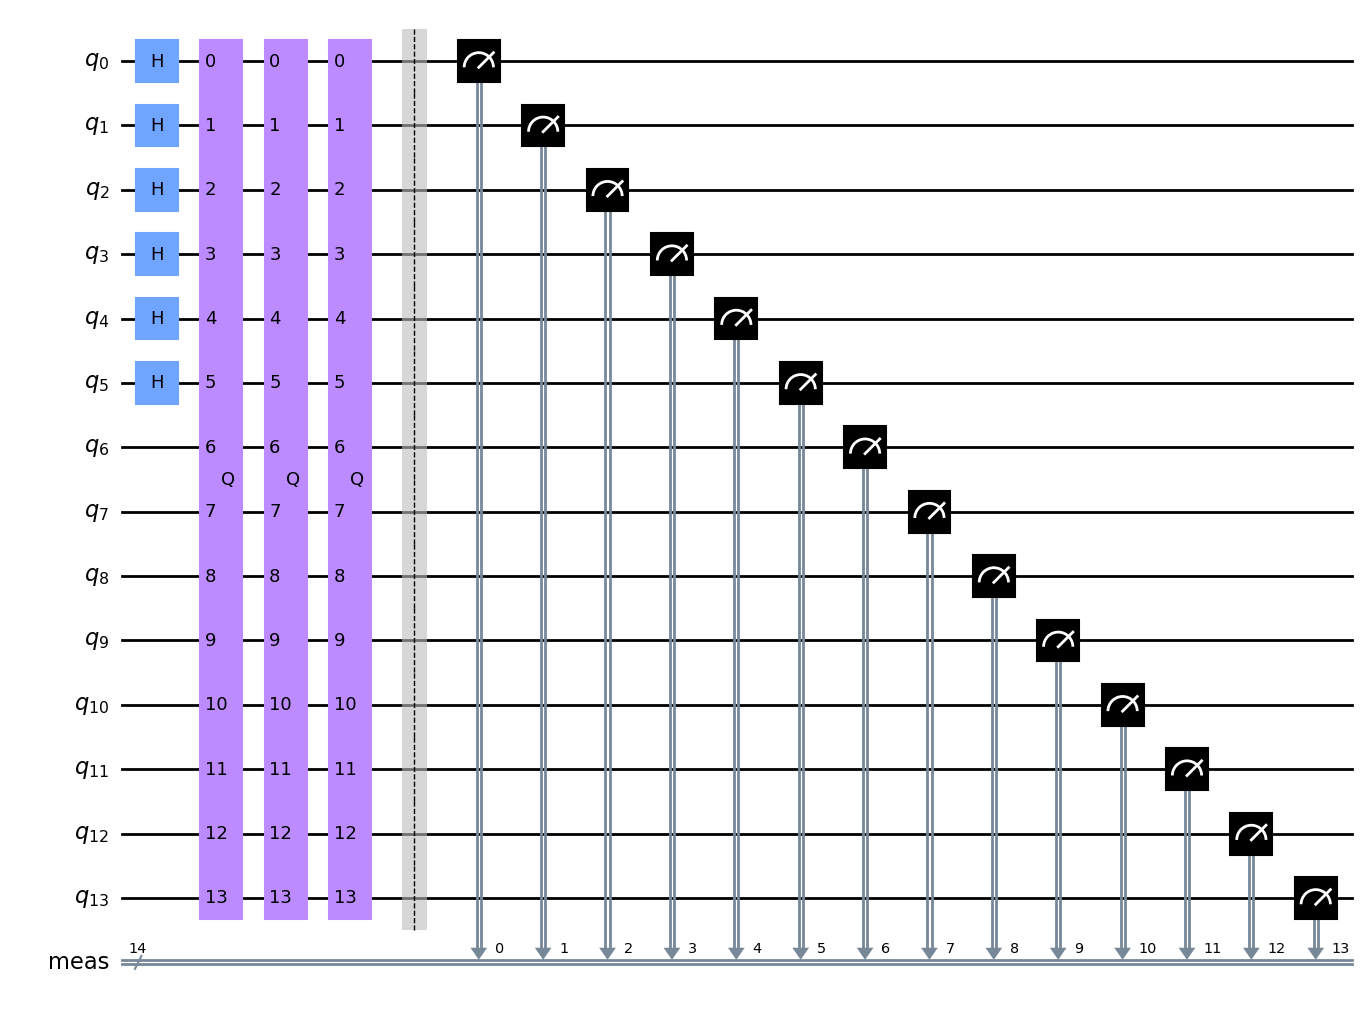

In [12]:
check_if_bipartite(n,edges)

- 5-nodes not bipartite graph example

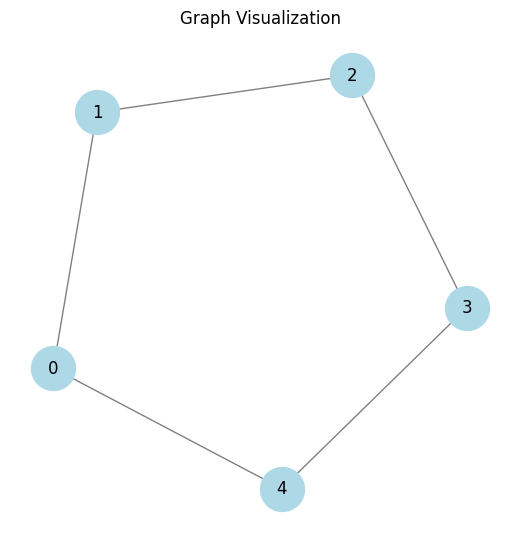

In [13]:
n=5
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)]
visualize_graph(edges)

iterations: 2
❌ Graph is not bipartite


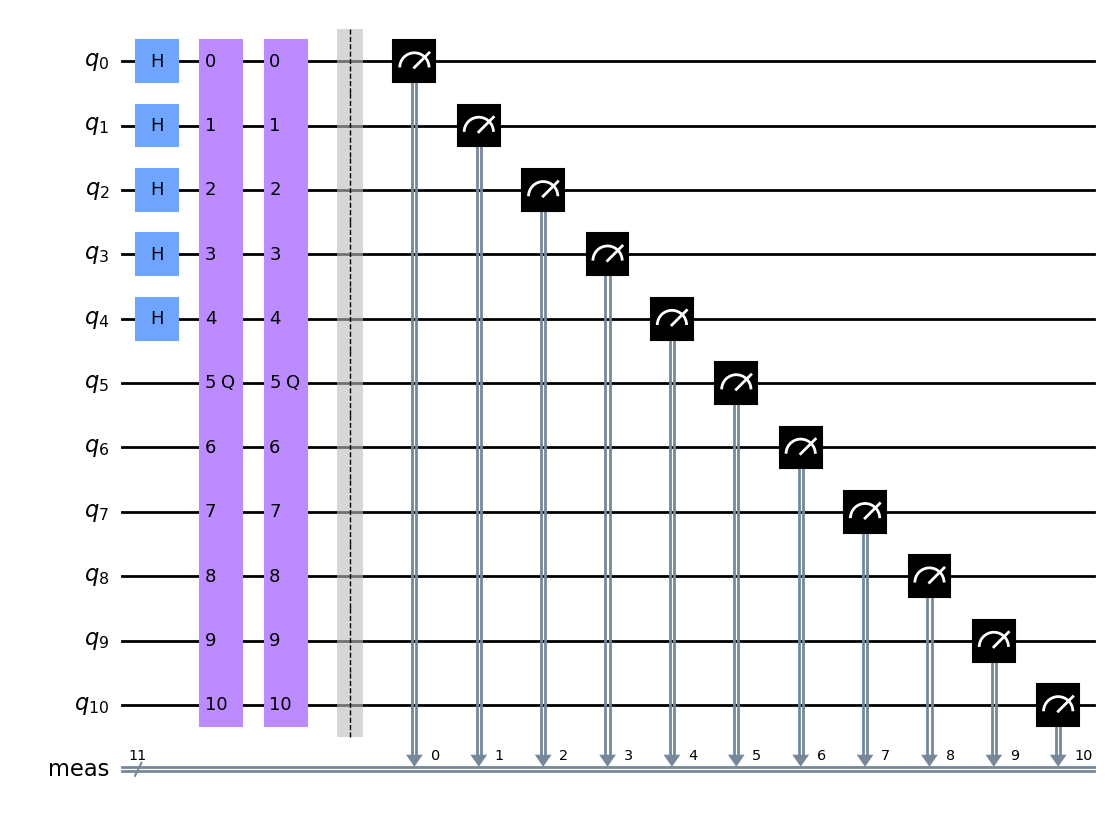

In [37]:
check_if_bipartite(n,edges)

## Code Dissection

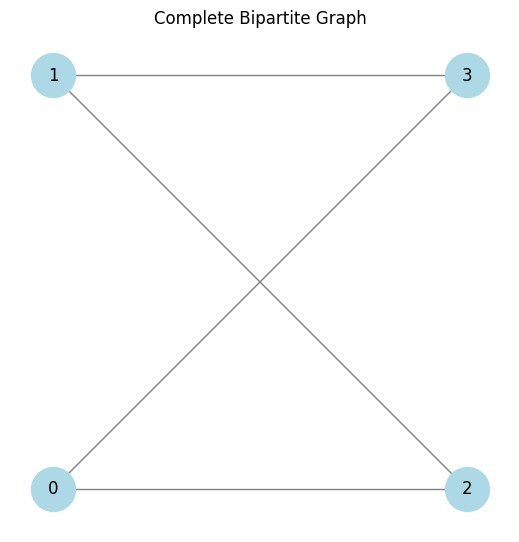

num_edges: 4
total_qubits: 9
edge_ancillas: [4, 5, 6, 7]
flag_qubit: 8


In [6]:
n_vertices = 4
edges = [(i, j) for i in range(2) for j in range(2, 4)]  # Complete bipartite graph K₅,₅

visualize_bipartite_graph(n_vertices,edges)

num_edges = len(edges)
total_qubits = n_vertices + num_edges + 1
edge_ancillas = list(range(n_vertices, n_vertices + num_edges))
flag_qubit = n_vertices + num_edges

print("num_edges:",num_edges)
print("total_qubits:",total_qubits)
print("edge_ancillas:",edge_ancillas)
print("flag_qubit:",flag_qubit) 

In [7]:
# Check each edge for same-color violation
for i, (u, v) in enumerate(edges):
    edge_anc = edge_ancillas[i]
    print("adding cnot gate between u",u,"and edge_anc",edge_anc)
    print("adding cnot gate between v",v,"and edge_anc",edge_anc)
    print("adding x gate to edge_anc",edge_anc)

adding cnot gate between u 0 and edge_anc 4
adding cnot gate between v 2 and edge_anc 4
adding x gate to edge_anc 4
adding cnot gate between u 0 and edge_anc 5
adding cnot gate between v 3 and edge_anc 5
adding x gate to edge_anc 5
adding cnot gate between u 1 and edge_anc 6
adding cnot gate between v 2 and edge_anc 6
adding x gate to edge_anc 6
adding cnot gate between u 1 and edge_anc 7
adding cnot gate between v 3 and edge_anc 7
adding x gate to edge_anc 7


In [8]:
 # Aggregate violations using XOR operation
for anc in edge_ancillas:
    print("adding CNOT gate between anc",anc,"and flag_qubit",flag_qubit)

adding CNOT gate between anc 4 and flag_qubit 8
adding CNOT gate between anc 5 and flag_qubit 8
adding CNOT gate between anc 6 and flag_qubit 8
adding CNOT gate between anc 7 and flag_qubit 8


Figure(1458.05x785.944)


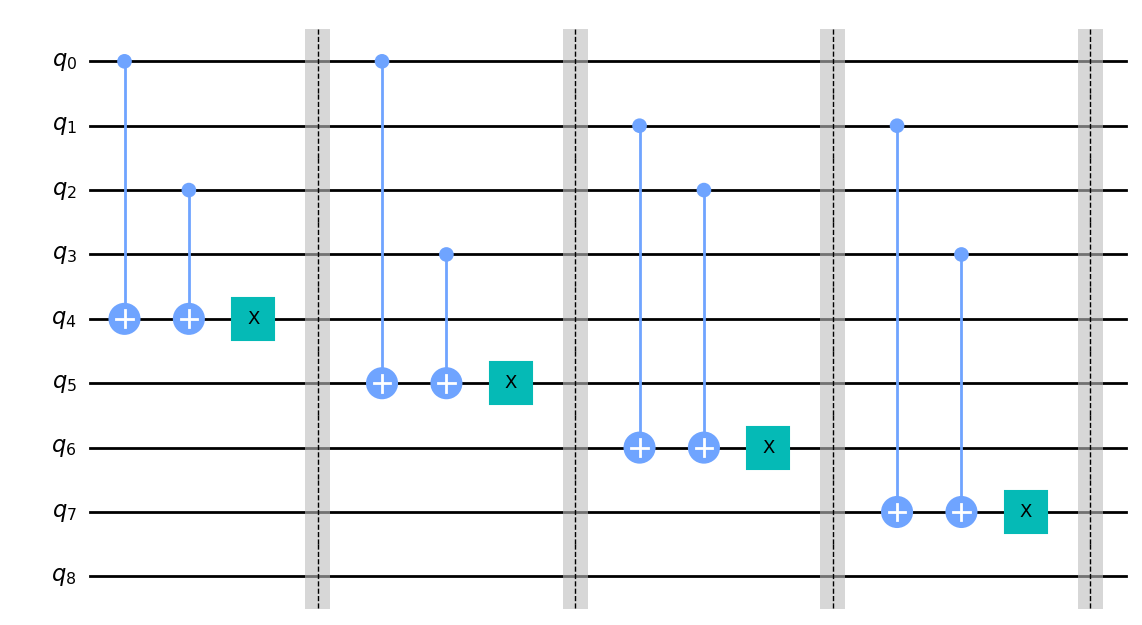

In [9]:
qc = QuantumCircuit(total_qubits, name="Oracle")
# Check each edge for same-color violation
for i, (u, v) in enumerate(edges):
    edge_anc = edge_ancillas[i]
    qc.cx(u, edge_anc)
    qc.cx(v, edge_anc)
    qc.x(edge_anc)
    qc.barrier()

print(qc.draw(output='mpl', fold=100))

In [10]:
#edges
for i, (u, v) in enumerate(edges):
    print(f"edge# {i} edge ({u}, {v})")

edge# 0 edge (0, 2)
edge# 1 edge (0, 3)
edge# 2 edge (1, 2)
edge# 3 edge (1, 3)


Figure(872.774x535.111)


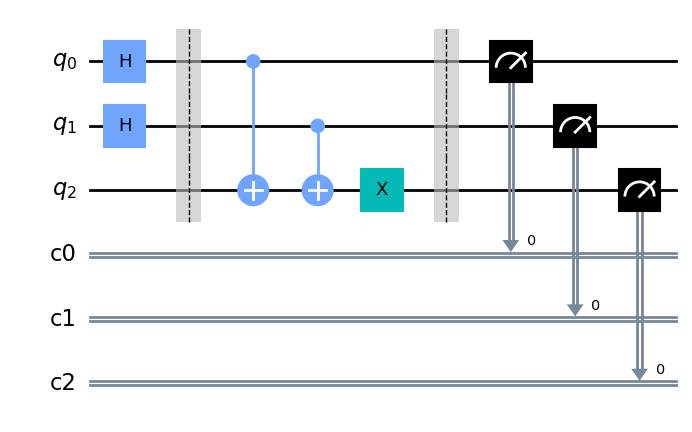

In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q = QuantumRegister(3, 'q')
qc = QuantumCircuit(q, name="Oracle")
c = [ ClassicalRegister(1) for _ in range(3)]
for register in c:
    qc.add_register(register)
    
qc.h(0)
qc.h(1)
qc.barrier()

# Check each edge for same-color violation
qc.cx(0, 2)
qc.cx(1, 2)
qc.x(2)
qc.barrier()

qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])

print(qc.draw(output='mpl', fold=100))

In [12]:
# Execute on QASM simulator
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=1000).result()
counts = result.get_counts()
print("counts:",counts)

counts: {'1 0 0': 236, '0 0 1': 249, '0 1 0': 269, '1 1 1': 246}


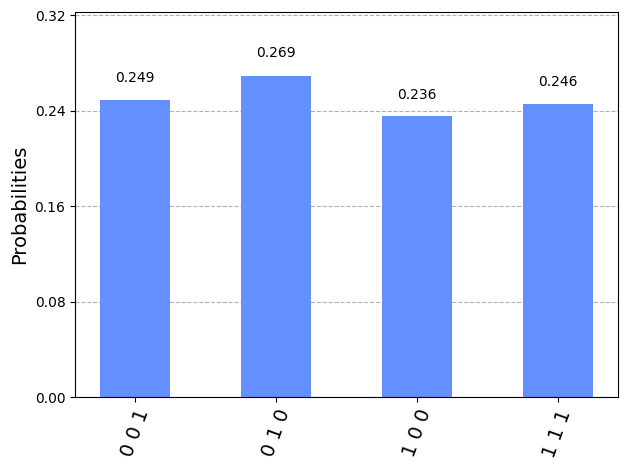

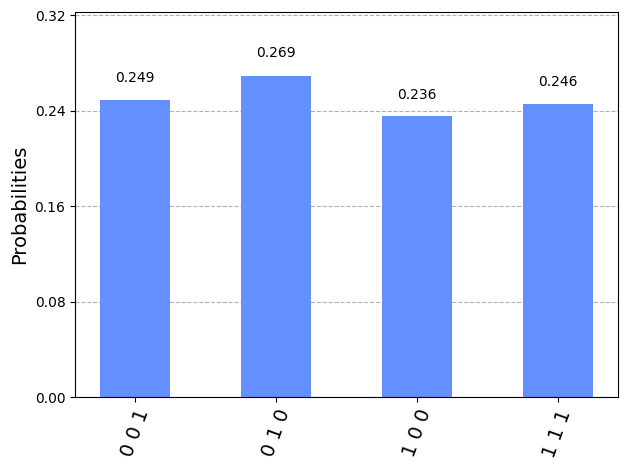

In [13]:
from qiskit.tools.visualization import plot_histogram

plot_histogram(counts)

Figure(2811.45x1538.44)


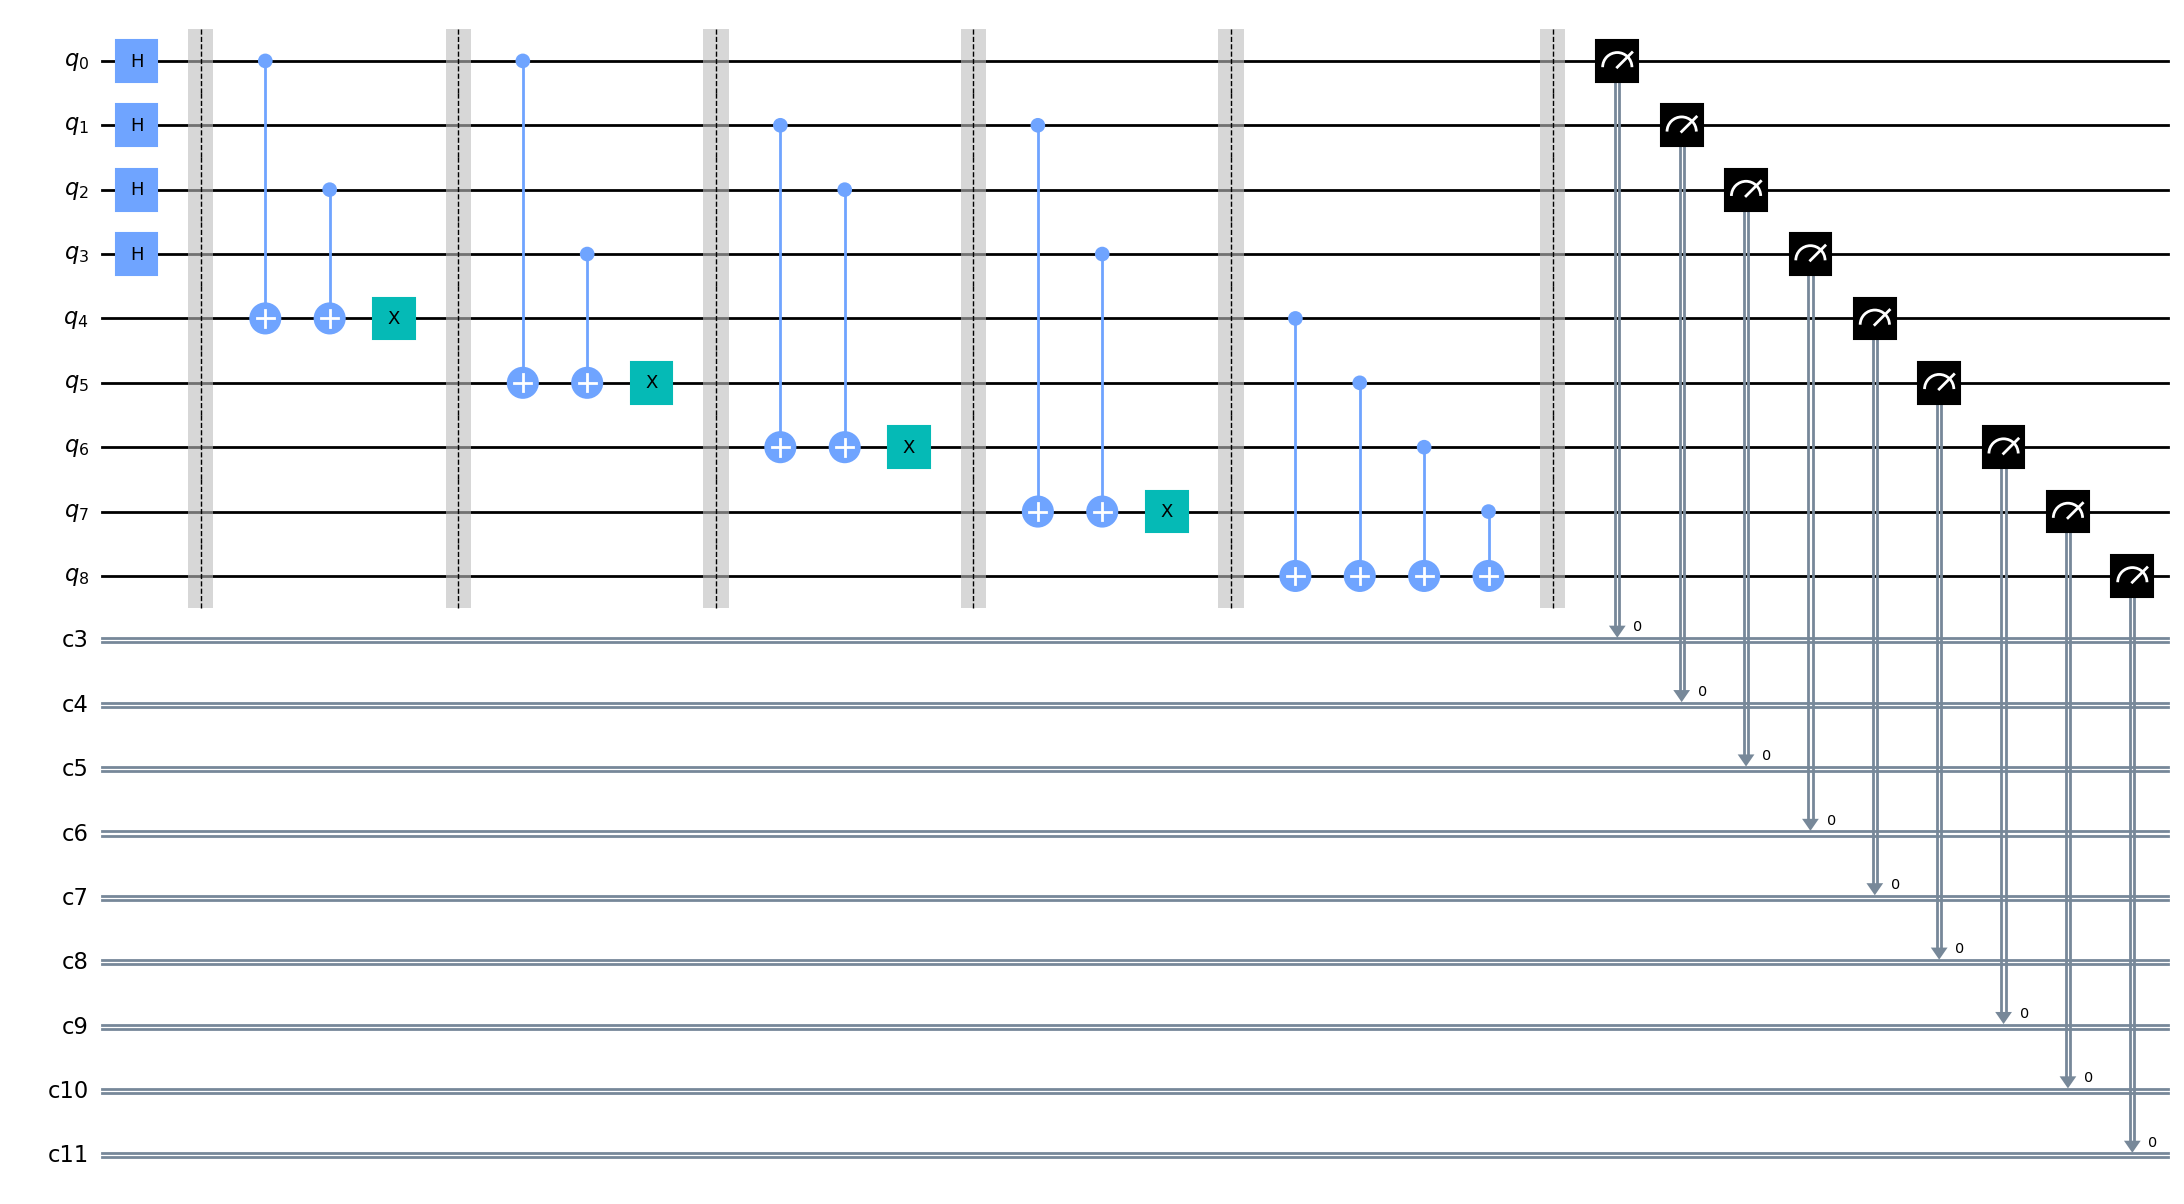

In [14]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q = QuantumRegister(9, 'q')
qc = QuantumCircuit(q, name="Oracle")
c = [ ClassicalRegister(1) for _ in range(9)]
for register in c:
    qc.add_register(register)
    
# Check each edge for same-color violation
for i in range(4):
    qc.h(i)
qc.barrier()

for i, (u, v) in enumerate(edges):
    edge_anc = edge_ancillas[i]
    qc.cx(u, edge_anc)
    qc.cx(v, edge_anc)
    qc.x(edge_anc)
    qc.barrier()

# Aggregate violations using XOR operation
edge_ancillas = [4, 5, 6, 7]
flag_qubit=8
for anc in edge_ancillas:
    qc.cx(anc, flag_qubit)
qc.barrier()

for i in range(9):
    qc.measure(q[i], c[i])  

print(qc.draw(output='mpl', fold=100))

In [15]:
# Execute on QASM simulator
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=1000).result()
counts = result.get_counts()
print("counts:",counts)

counts: {'0 1 0 0 1 1 0 1 0': 65, '0 0 1 1 0 1 0 0 1': 51, '0 0 1 0 1 1 0 0 0': 61, '0 0 0 1 1 0 0 1 0': 71, '0 1 1 1 1 1 1 1 1': 67, '0 0 1 1 0 0 1 1 0': 67, '0 0 1 0 1 0 1 1 1': 60, '0 0 0 0 0 0 0 1 1': 63, '0 1 0 0 1 0 1 0 1': 65, '0 1 1 0 0 0 0 0 1': 57, '0 1 1 1 1 0 0 0 0': 59, '0 1 0 1 0 1 0 1 1': 68, '0 1 0 1 0 0 1 0 0': 67, '0 0 0 1 1 1 1 0 1': 50, '0 0 0 0 0 1 1 0 0': 61, '0 1 1 0 0 1 1 1 0': 68}


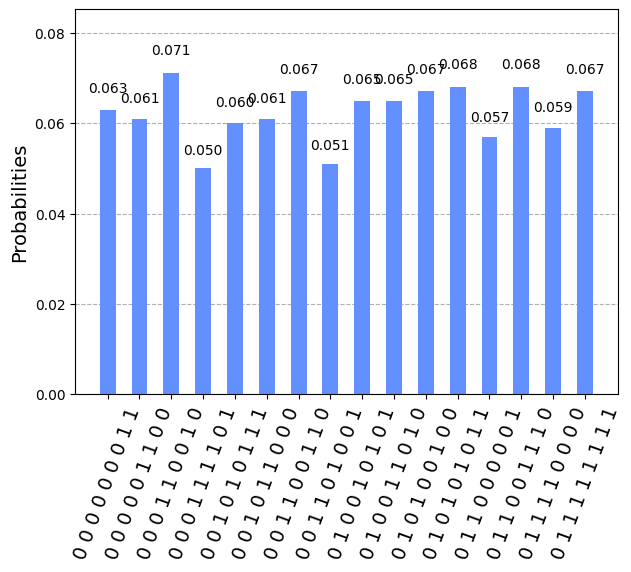

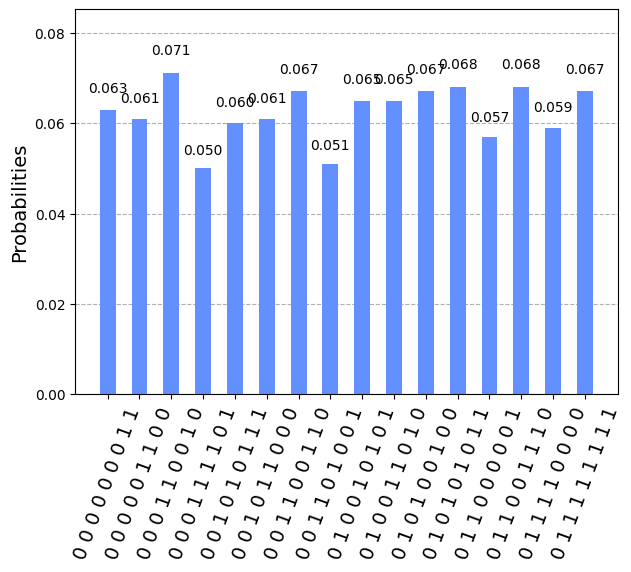

In [16]:
#flag_qubit always 0 as expected
from qiskit.tools.visualization import plot_histogram

plot_histogram(counts)

- example where flag_qubit is set to 1 as expected

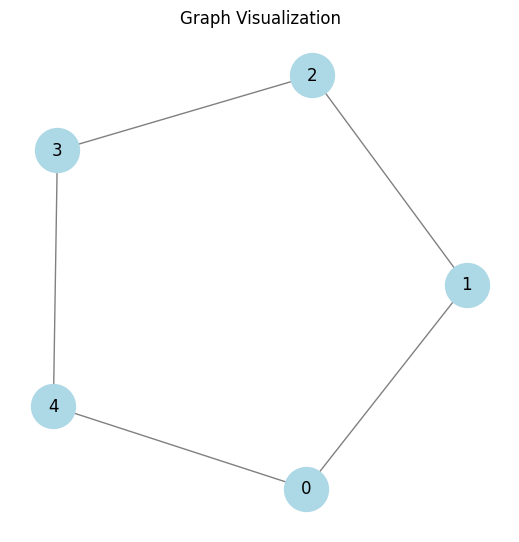

num_edges: 5
total_qubits: 10
edge_ancillas: [4, 5, 6, 7, 8]
flag_qubit: 9


In [17]:
n=5
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)]

visualize_graph(edges)

num_edges = len(edges)
total_qubits = n_vertices + num_edges + 1
edge_ancillas = list(range(n_vertices, n_vertices + num_edges))
flag_qubit = n_vertices + num_edges

print("num_edges:",num_edges)
print("total_qubits:",total_qubits)
print("edge_ancillas:",edge_ancillas)
print("flag_qubit:",flag_qubit)

Figure(3313.32x1705.67)


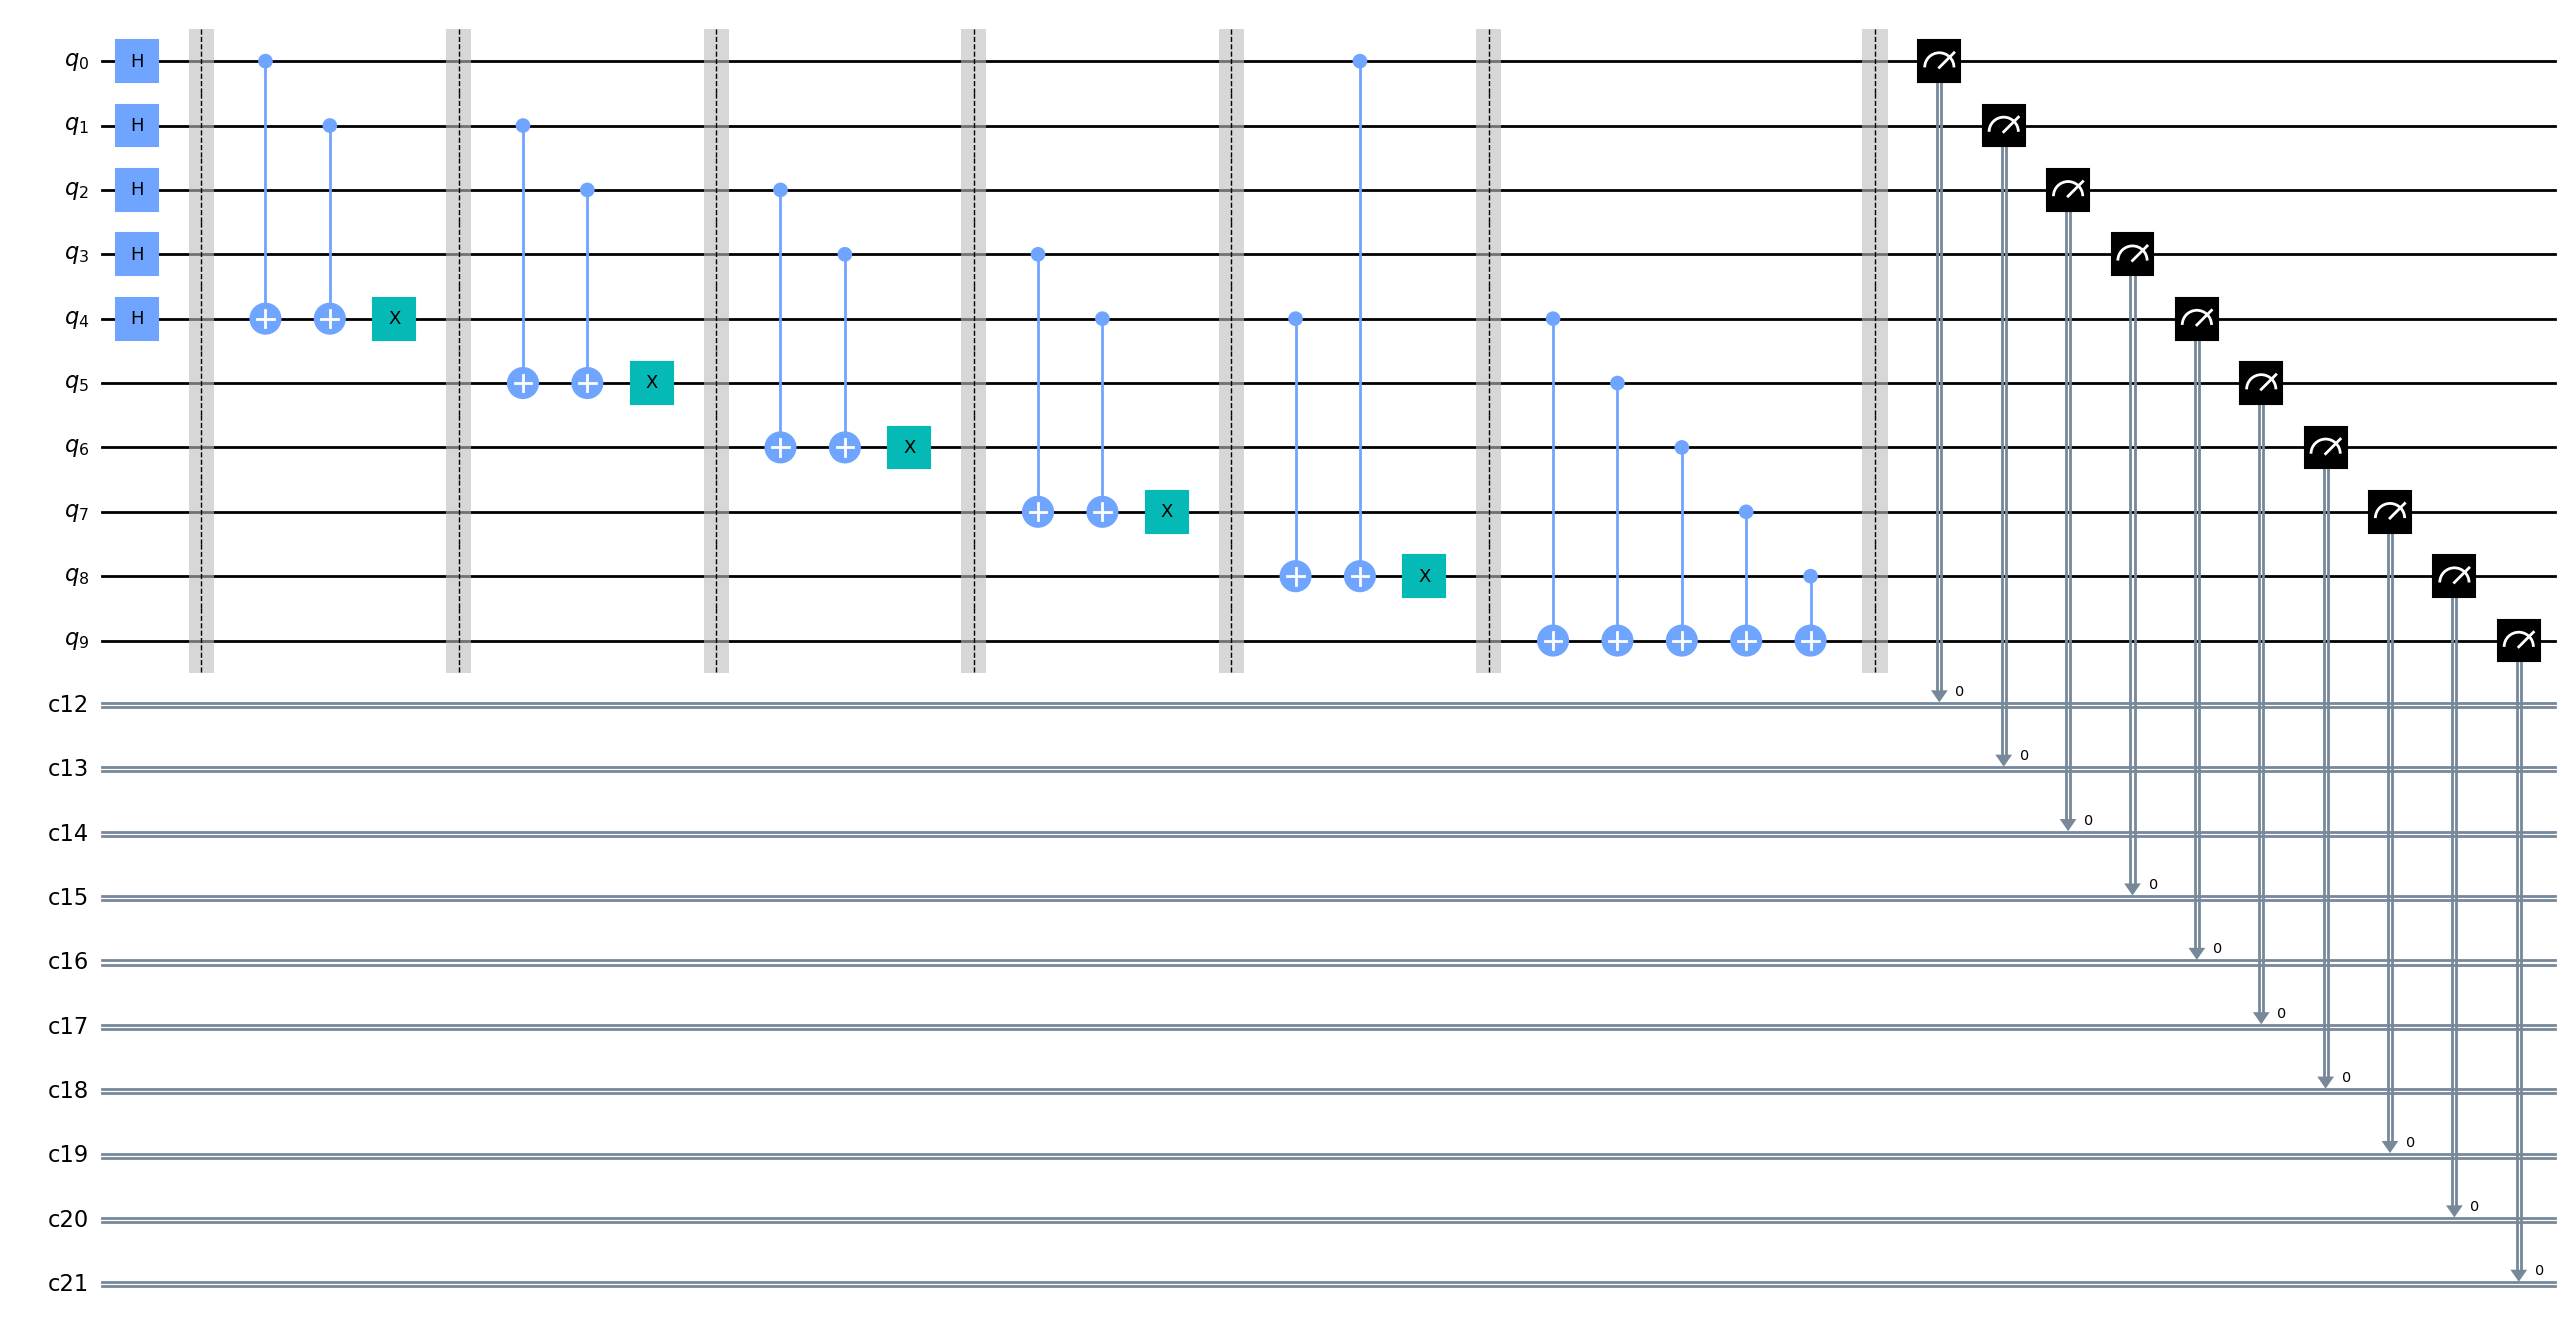

In [18]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q = QuantumRegister(10, 'q')
qc = QuantumCircuit(q, name="Oracle")
c = [ ClassicalRegister(1) for _ in range(10)]
for register in c:
    qc.add_register(register)
    
# Check each edge for same-color violation
for i in range(5):
    qc.h(i)
qc.barrier()

for i, (u, v) in enumerate(edges):
    edge_anc = edge_ancillas[i]
    qc.cx(u, edge_anc)
    qc.cx(v, edge_anc)
    qc.x(edge_anc)
    qc.barrier()

# Aggregate violations using XOR operation
edge_ancillas = [4, 5, 6, 7, 8]
flag_qubit=9
for anc in edge_ancillas:
    qc.cx(anc, flag_qubit)
qc.barrier()

for i in range(10):
    qc.measure(q[i], c[i])  

print(qc.draw(output='mpl', fold=100))

In [19]:
# Execute on QASM simulator
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=1000).result()
counts = result.get_counts()
print("counts:",counts)

counts: {'1 0 1 1 0 1 1 1 0 0': 41, '0 1 1 0 0 0 0 1 0 0': 26, '0 1 0 1 1 1 0 0 0 1': 26, '1 0 0 0 1 0 1 0 0 1': 23, '0 0 1 1 1 1 1 1 1 0': 19, '1 1 1 0 0 1 1 0 1 1': 30, '0 1 1 0 1 1 1 0 0 1': 36, '1 0 0 1 1 1 0 0 0 0': 40, '1 0 0 1 0 0 1 1 0 1': 33, '1 1 0 0 0 0 1 0 1 0': 29, '1 0 1 0 1 1 1 0 0 0': 45, '0 1 0 0 0 1 0 1 0 1': 29, '0 0 0 1 1 0 1 1 1 1': 27, '1 1 1 0 1 0 0 1 1 0': 42, '1 1 1 1 1 1 1 1 1 1': 39, '1 0 1 0 0 0 0 1 0 1': 32, '0 0 0 1 0 1 0 0 1 0': 27, '1 0 1 1 1 0 0 0 0 1': 41, '0 1 1 1 0 1 1 1 0 1': 30, '0 0 1 0 1 0 0 1 1 1': 27, '0 1 0 1 0 0 1 1 0 0': 34, '0 0 1 0 0 1 1 0 1 0': 37, '1 0 0 0 0 1 0 1 0 0': 29, '0 0 0 0 0 0 1 0 1 1': 30, '1 1 0 0 1 1 0 1 1 1': 33, '0 0 0 0 1 1 0 1 1 0': 29, '0 1 1 1 1 0 0 0 0 0': 28, '1 1 0 1 1 0 1 1 1 0': 29, '0 1 0 0 1 0 1 0 0 0': 26, '1 1 0 1 0 1 0 0 1 1': 31, '1 1 1 1 0 0 0 0 1 0': 31, '0 0 1 1 0 0 0 0 1 1': 21}


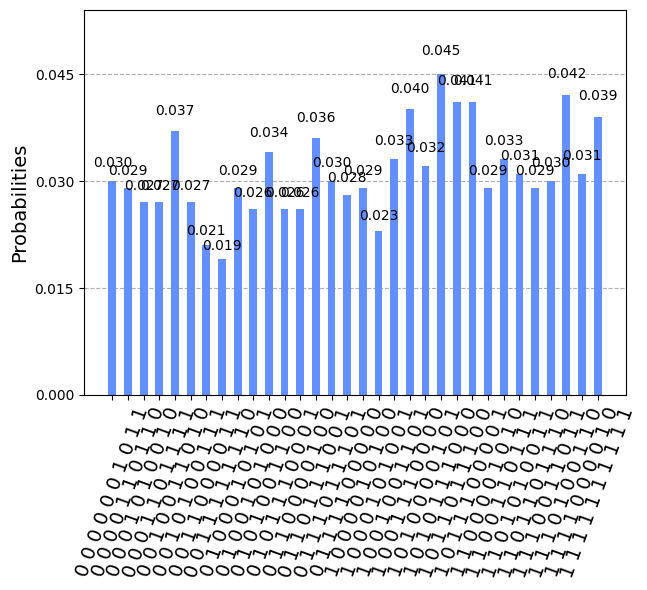

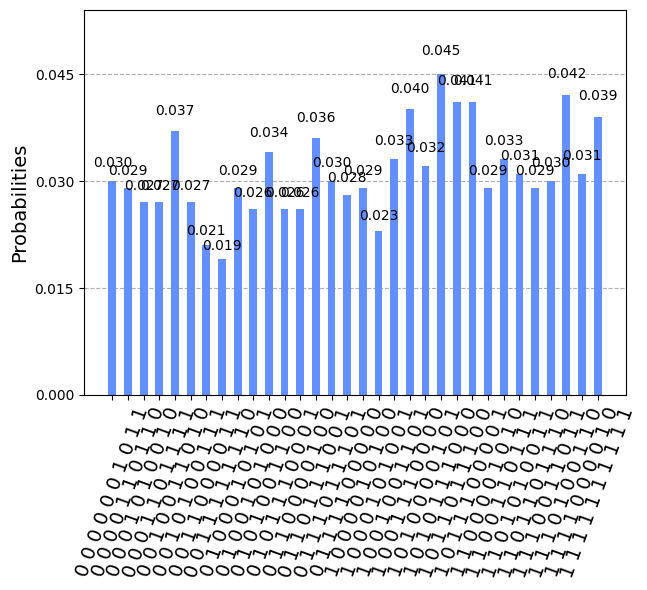

In [20]:
from qiskit.tools.visualization import plot_histogram

plot_histogram(counts)

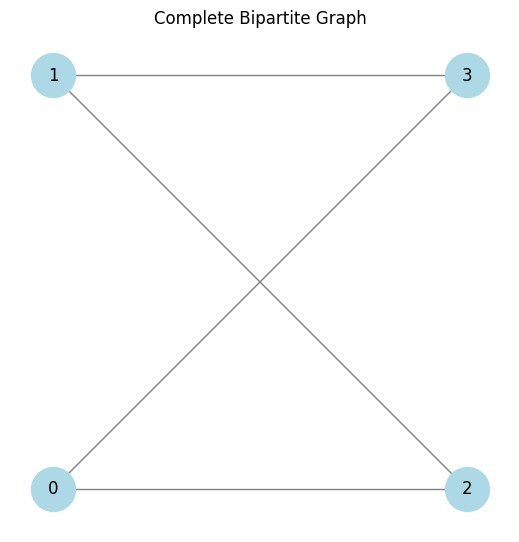

num_edges: 4
total_qubits: 9
edge_ancillas: [4, 5, 6, 7]
flag_qubit: 8
input bits: 1100
node_bits (reversed): 0011
returning 2 partitions A and B:


([0, 1], [2, 3])

In [10]:
n_vertices = 4
edges = [(i, j) for i in range(2) for j in range(2, 4)]  # Complete bipartite graph K₅,₅

visualize_bipartite_graph(n_vertices,edges)

num_edges = len(edges)
total_qubits = n_vertices + num_edges + 1
edge_ancillas = list(range(n_vertices, n_vertices + num_edges))
flag_qubit = n_vertices + num_edges

print("num_edges:",num_edges)
print("total_qubits:",total_qubits)
print("edge_ancillas:",edge_ancillas)
print("flag_qubit:",flag_qubit) 

def get_partitions_dissect(bitstring, n_vertices):
    """Extracts partitions from measurement result"""
    reversed_bits = bitstring[::-1]
    node_bits = reversed_bits[:n_vertices]
    print("input bits:",bitstring)
    print("node_bits (reversed):",node_bits)
    print("returning 2 partitions A and B:")
    return (
        [i for i, bit in enumerate(node_bits) if bit == '0'],
        [i for i, bit in enumerate(node_bits) if bit == '1']
    )
    
get_partitions_dissect('1100', n_vertices)

In [13]:
def is_valid_dissect(bitstring, edges, n_vertices):
    """Validates bipartition against edges"""
    set_a, set_b = get_partitions(bitstring, n_vertices)
    print('set_a:',set_a,'set_b:',set_b)
    print("verify if all edges connect nodes from different partitions:")
    return all((u in set_a) != (v in set_a) for u, v in edges)

is_valid_dissect('1100', edges, n_vertices)

set_a: [0, 1] set_b: [2, 3]
verify if all edges connect nodes from different partitions:


True